In [19]:
from gen_cities import GenCities
from greedy import GreedyTSP
from qiskit.aqua.translators.ising import max_cut, tsp
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx
import logging
from qiskit.aqua import set_qiskit_aqua_logging
from qiskit.aqua.algorithms import VQE, ExactEigensolver

In [20]:
n = 4

In [21]:
def generateTSP(n):
    cityObj = GenCities(n)
    print(cityObj.cities)
    cityObj.print_city_map()
    return cityObj

{4: [[0.4300815796372065, 0.8867105337693268], 0], 3: [[0.08874966004713668, 0.5109665592594147], 0], 2: [[0.470490007476639, 0.2515515201177656], 0], 1: [[1.6993084530728197, 0.4780813393844611], 0]}


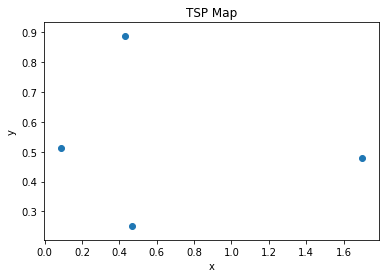

In [22]:
for i in range(1):
    cityObj = generateTSP(n)
    

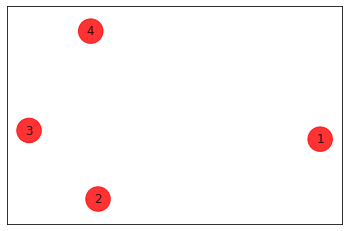

In [24]:
G = nx.Graph()
G.add_nodes_from([k for k,v in cityObj.cities.items()])
colors = ['r' for node in G.nodes()]
pos = {k:v[0] for k,v in cityObj.cities.items()}
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)


In [25]:
cities = cityObj.cities
cities

{4: [[0.4300815796372065, 0.8867105337693268], 0],
 3: [[0.08874966004713668, 0.5109665592594147], 0],
 2: [[0.470490007476639, 0.2515515201177656], 0],
 1: [[1.6993084530728197, 0.4780813393844611], 0]}

In [26]:
dist = lambda x1, y1, x2, y2: np.sqrt((x1 - y1) ** 2 + (x2
                - y2) ** 2)
def produce_matrix(cities): 
    x, y = {}, {}
    for k,v in cities.items():
        xi, yi = v[0][0], v[0][1] 
        x[k] = float(xi)
        y[k] = float(yi)
 
    V = x.keys()
    c = np.zeros((n, n))
    for i in V:
        for j in V:
            # i edited so that c is index from 0
            c[int(i)-1, int(j)-1] = dist(x[i], y[i], x[j], y[j])
            c[int(j)-1, int(i)-1] = c[int(i)-1, int(j)-1]
    #print(c)
    return c
matrix = produce_matrix(cities)

## Docplex Solver

In [10]:
from docplex.mp.model import Model
from qiskit.aqua.translators.ising import docplex

In [11]:
def draw_tsp_solution(G, order, colors, pos):
    G2 = G.copy()
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

In [ ]:
mdl = Model(name='tsp')
x = {(k,m): mdl.binary_var(name='x_{0}_{1}'.format(k,m)) for m in range(1,len(table)+1) \
     for k,v in table.items()}
print(x)

# Object function
tsp_func = mdl.sum(table[i][j] * x[(i,p)] * x[(j,p)] for i in range(1, len(table)+1) for j in range(1,len(table)+1) \
     for p in range(1, len(table)+1))

print(tsp_func)
mdl.minimize(tsp_func)

# Constrains
for i in range(1, len(table)+1):
    mdl.add_constraint(mdl.sum(x[(i,p)] for p in range(1, len(table)+1)) == 1)
for p in range(1, len(table)+1):
    mdl.add_constraint(mdl.sum(x[(i,p)] for i in range(1, len(table)+1)) == 1)

In [30]:
mdl = Model(name='tsp')
x = {(i,p): mdl.binary_var(name='x_{0}_{1}'.format(i,p)) for i in range(n) for p in range(n)}

print(x)

# Object function
tsp_func = mdl.sum(matrix[i,j] * x[(i,p)] * x[(j,(p+1)%n)] for i in range(n) for j in range(n) for p in range(n))
print(tsp_func)
mdl.minimize(tsp_func)

# Constrains
for i in range(n):
    mdl.add_constraint(mdl.sum(x[(i,p)] for p in range(n)) == 1)
for p in range(n):
    mdl.add_constraint(mdl.sum(x[(i,p)] for i in range(n)) == 1)

{(0, 0): docplex.mp.Var(type=B,name='x_0_0'), (0, 1): docplex.mp.Var(type=B,name='x_0_1'), (0, 2): docplex.mp.Var(type=B,name='x_0_2'), (0, 3): docplex.mp.Var(type=B,name='x_0_3'), (1, 0): docplex.mp.Var(type=B,name='x_1_0'), (1, 1): docplex.mp.Var(type=B,name='x_1_1'), (1, 2): docplex.mp.Var(type=B,name='x_1_2'), (1, 3): docplex.mp.Var(type=B,name='x_1_3'), (2, 0): docplex.mp.Var(type=B,name='x_2_0'), (2, 1): docplex.mp.Var(type=B,name='x_2_1'), (2, 2): docplex.mp.Var(type=B,name='x_2_2'), (2, 3): docplex.mp.Var(type=B,name='x_2_3'), (3, 0): docplex.mp.Var(type=B,name='x_3_0'), (3, 1): docplex.mp.Var(type=B,name='x_3_1'), (3, 2): docplex.mp.Var(type=B,name='x_3_2'), (3, 3): docplex.mp.Var(type=B,name='x_3_3')}
1.727x_0_0*x_0_1+1.727x_0_0*x_0_3+1.241x_0_0*x_1_1+1.241x_0_0*x_1_3+1.292x_0_0*x_2_1+1.292x_0_0*x_2_3+1.304x_0_0*x_3_1+1.304x_0_0*x_3_3+1.727x_0_1*x_0_2+1.241x_0_1*x_1_0+1.241x_0_1*x_1_2+1.292x_0_1*x_2_0+1.292x_0_1*x_2_2+1.304x_0_1*x_3_0+1.304x_0_1*x_3_2+1.727x_0_2*x_0_3+1.241x_

In [31]:
qubitOp_docplex, offset_docplex = docplex.get_qubitops(mdl)

energy: -932.8698542852025
tsp objective: 3.577967792576942
feasible: True
solution objective: 3.5779677925738413
solution: [2, 4, 1, 3]


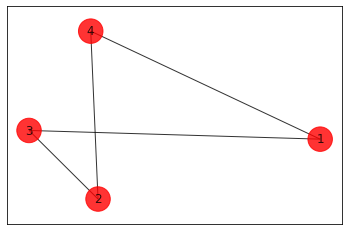

In [32]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = ExactEigensolver(qubitOp_docplex, k=1)
result = ee.run()

"""
algorithm_cfg = {
    'name': 'ExactEigensolver',
}

params = {
    'problem': {'name': 'ising'},
    'algorithm': algorithm_cfg
}
result = run_algorithm(params,algo_input)
"""
print('energy:', result['energy'])
print('tsp objective:', result['energy'] + offset_docplex)
x = tsp.sample_most_likely(result['eigvecs'][0])
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)

print('solution objective:', tsp.tsp_value(z, matrix))
z = [i+1 for i in z]
print('solution:', z)
draw_tsp_solution(G, z, colors, pos)
